# Introduction

This notebook is based on ensamblling/stacking in Python tutorial.
https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python
During implementation of this notebook I learn the concept and try to improve the results.


In [355]:
# Load in our libraries
import pandas as pd 
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cross_validation import KFold;

# Feature exploration, engineering and cleaning

## Loading data

In [356]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

datasets = [test, train]
PassengerId = test['PassengerId']

## Basic data exploration 

In [357]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [358]:
test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [359]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [360]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [361]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [362]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [363]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

As we can see above, Age and Cabin columns have many null values. I will need to fill Age using mean and probably drop Cabin entirely. There is also possibility that Cabin wasn't tracked in case of cheaper tickets so I can use it binary.

5 columns are non-numerical, I will need to transform them.

## Feature engineering

### Handling missing data

In [364]:
for data in datasets:
    data['Age'].fillna(data['Age'].mean(), axis=0, inplace=True)

In [365]:
for data in datasets:
    data['Embarked'] = data["Embarked"].apply(lambda x: 'S' if type(x) == float else x)

In [366]:
test['Fare'].fillna(0, axis=0, inplace=True)

### Mapping

In [367]:
for data in datasets:
    data['Sex'] = data["Sex"].apply(lambda x: 0 if x == "male" else 1)

In [368]:
for data in datasets:
    data['Embarked'] = data["Embarked"].map({'S': 0, 'Q': 1, 'C': 2})

### Creating additional features

In [369]:
for data in datasets:
    data['Has_Cabin'] = data["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [370]:
for data in datasets:
    data['Name_lenght'] = data["Name"].apply(len)

In [371]:
# Family size should be as much informative as Is_Alone feature, so I will keep it this way
for data in datasets:
    data['Family_size'] = data["SibSp"] + data["Parch"]

In [372]:
for data in datasets:
    data['IsAlone'] = 0
    data.loc[data['Family_size'] == 1, 'IsAlone'] = 1

In [373]:
def get_title(name):
    title = re.search(r' ([A-Za-z]+)\.', name) #search for A-Z string with dot after it and space before it
    if title:
        return title[0]
    return ""

for data in datasets:
    data['Title'] = data['Name'].apply(get_title)

In [374]:
for data in datasets:
    tvc = data['Title'].value_counts()/len(data)*100
    rare = tvc[tvc < 10].index.tolist()
    data['Rare_title'] = data['Title'].apply(lambda x: 1 if x in rare else 0)

### Feature selection #1

In [375]:
drop_columns = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Title', 'Cabin']

for data in datasets:
    data.drop(drop_columns, axis=1, inplace=True)

In [376]:
for data in datasets:
    data.info()
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
Pclass         418 non-null int64
Sex            418 non-null int64
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Embarked       418 non-null int64
Has_Cabin      418 non-null int64
Name_lenght    418 non-null int64
Family_size    418 non-null int64
IsAlone        418 non-null int64
Rare_title     418 non-null int64
dtypes: float64(2), int64(10)
memory usage: 39.3 KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       891 non-null int64
Has_Cabin      891 non-null int64
Name_lenght    

For now we have numerical values in all columns. Now they need normalization.

### Normalization

In [377]:
norm_test = (test-test.min())/(test.max()-test.min())
norm_train = (train-train.min())/(train.max()-train.min())

In [378]:
#norm_test = (test-test.mean())/test.std()
#norm_train = (train-train.mean())/train.std()

In [379]:
norm_test.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Has_Cabin,Name_lenght,Family_size,IsAlone,Rare_title
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,0.632775,0.363636,0.396975,0.055921,0.043594,0.069373,0.299043,0.217703,0.289665,0.083971,0.177033,0.066986
std,0.420919,0.481622,0.166617,0.112095,0.109048,0.109046,0.427248,0.413179,0.199425,0.151907,0.382154,0.250297
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.301068,0.000000,0.000000,0.015412,0.000000,0.000000,0.140000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.396975,0.000000,0.000000,0.028213,0.000000,0.000000,0.240000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.469207,0.125000,0.000000,0.061429,0.500000,0.000000,0.355000,0.100000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [380]:
norm_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Has_Cabin,Name_lenght,Family_size,IsAlone,Rare_title
0,1.0,0.0,0.452723,0.000,0.000000,0.015282,0.5,0.0,0.06,0.0,0.0,0.0
1,1.0,1.0,0.617566,0.125,0.000000,0.013663,0.0,0.0,0.38,0.1,1.0,0.0
2,0.5,0.0,0.815377,0.000,0.000000,0.018909,0.5,0.0,0.24,0.0,0.0,0.0
3,1.0,0.0,0.353818,0.000,0.000000,0.016908,0.0,0.0,0.06,0.0,0.0,0.0
4,1.0,1.0,0.287881,0.125,0.111111,0.023984,0.0,0.0,0.62,0.2,0.0,0.0


In [381]:
norm_train.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Has_Cabin,Name_lenght,Family_size,IsAlone,Rare_title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,0.654321,0.352413,0.367921,0.065376,0.063599,0.062858,0.231762,0.228956,0.213789,0.090460,0.180696,0.075196
std,0.486592,0.418036,0.477990,0.163383,0.137843,0.134343,0.096995,0.395752,0.420397,0.132594,0.161346,0.384982,0.263856
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.500000,0.000000,0.271174,0.000000,0.000000,0.015440,0.000000,0.000000,0.114286,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.367921,0.000000,0.000000,0.028213,0.000000,0.000000,0.185714,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.434531,0.125000,0.000000,0.060508,0.500000,0.000000,0.257143,0.100000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [382]:
norm_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Has_Cabin,Name_lenght,Family_size,IsAlone,Rare_title
0,0.0,1.0,0.0,0.271174,0.125,0.0,0.014151,0.0,0.0,0.157143,0.1,1.0,0.0
1,1.0,0.0,1.0,0.472229,0.125,0.0,0.139136,1.0,1.0,0.557143,0.1,1.0,0.0
2,1.0,1.0,1.0,0.321438,0.000,0.0,0.015469,0.0,0.0,0.142857,0.0,0.0,0.0
3,1.0,0.0,1.0,0.434531,0.125,0.0,0.103644,0.0,1.0,0.457143,0.1,1.0,0.0
4,0.0,1.0,0.0,0.434531,0.000,0.0,0.015713,0.0,0.0,0.171429,0.0,0.0,0.0


Now all the values are spread between 0 and 1.

# Finding correlations

## Correlation map

Now let's find correlations between features. Pearson correlation map is good tool for evaluation what features are correlated with target and other features. Seaborn will be used for this.

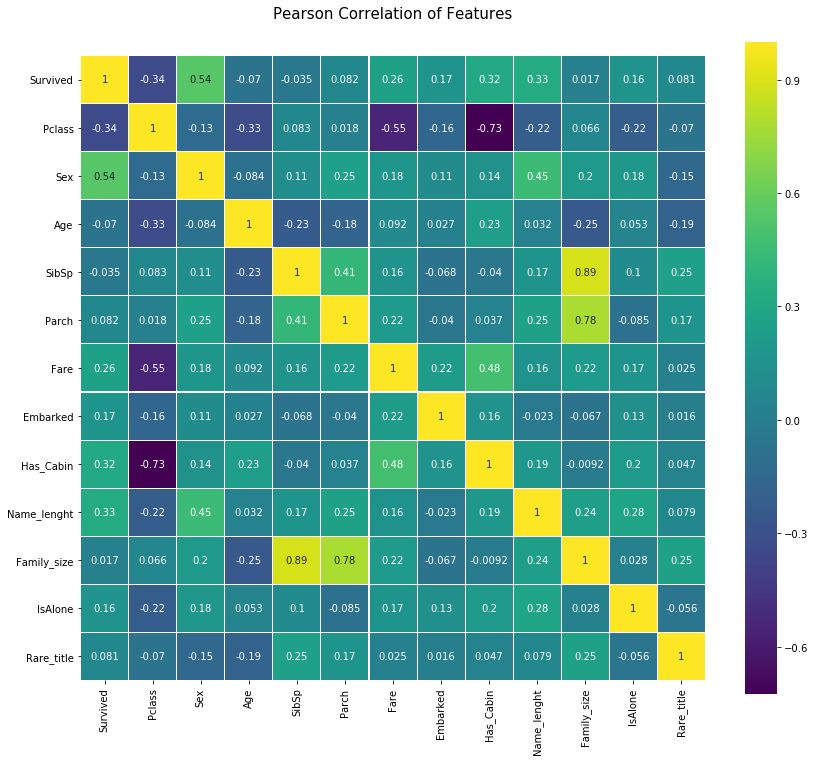

In [383]:
colormap = plt.cm.viridis
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(norm_train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

Now we can see that some of the features are correlated with other features, also that some of the does not have correlation with target. I will drop Has_Cabin (correlated with Pclass, less corelated with Survived), Fare is also candidate for dop (Pclass has that information and has higher correlation with target), Family_size is highy corelated with SibSp and Parch (I will leave both or one of them).

Further I will probably need to go back to feature engineering step to improve the result.

In [384]:
#Experimental drop of correlated features I will analyze outcome later
#norm_test.drop(['Has_Cabin', 'Fare', 'Family_size'],axis=1, inplace=True)
#norm_train.drop(['Has_Cabin', 'Fare', 'Family_size'],axis=1, inplace=True)

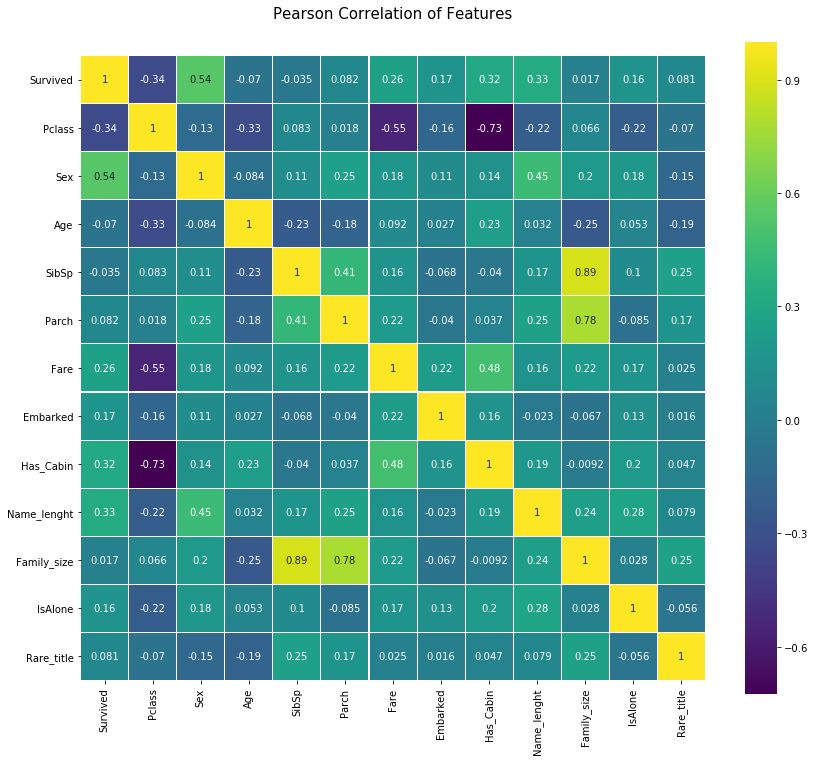

In [385]:
colormap = plt.cm.viridis
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(norm_train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

## Pair plots

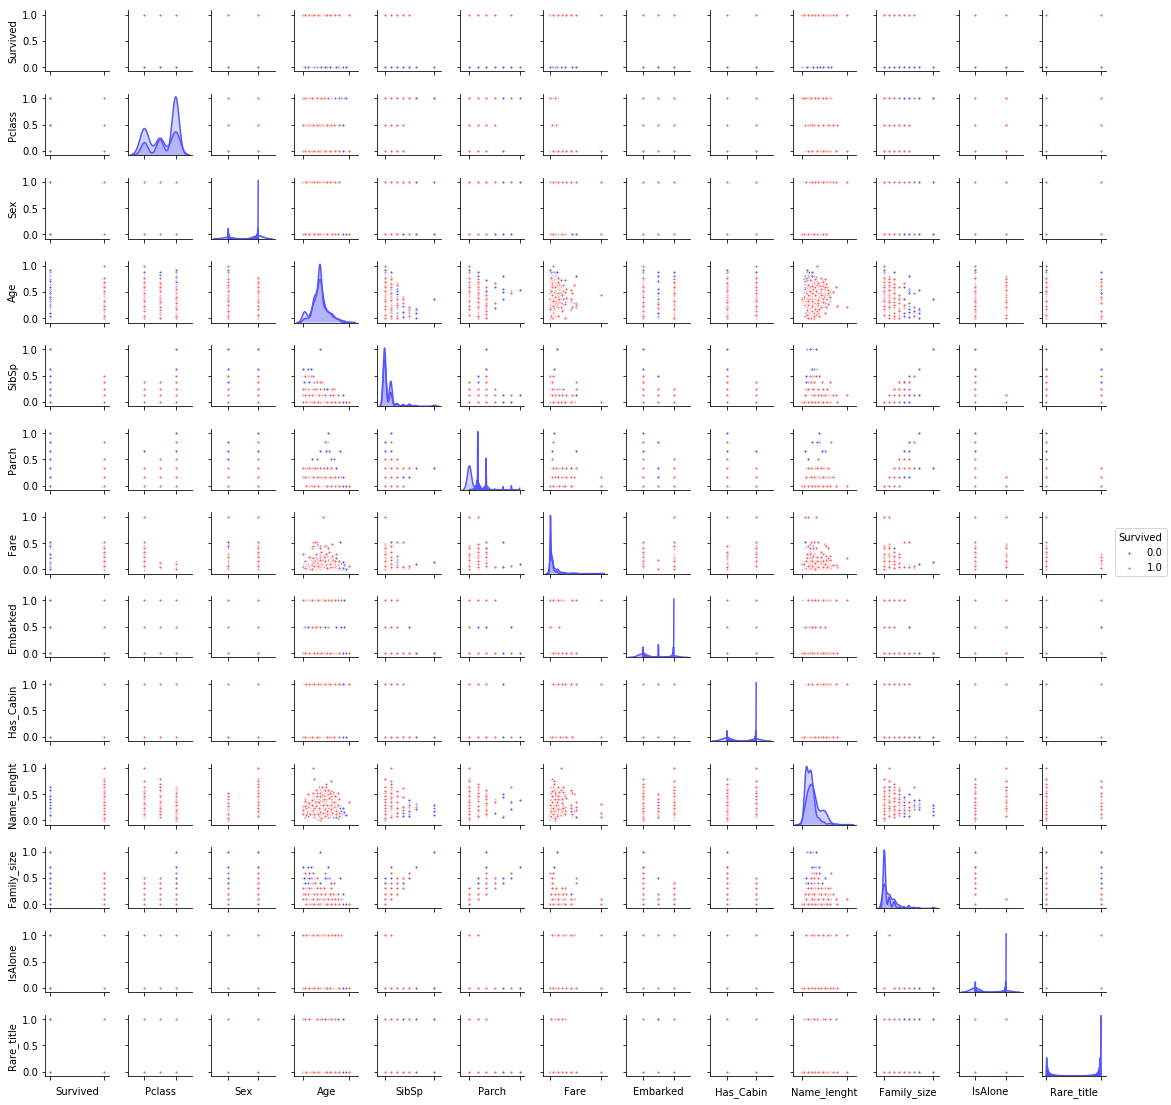

In [386]:
g = sns.pairplot(norm_train, hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])
plt.show()

# Ensembling & Stacking models

## Helpers implementation

In [387]:
ntrain = len(norm_train)
ntest = len(norm_test)
SEED = 0 
NFOLDS = 5
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

In [388]:
class SklearnHelper(object):
    def __init__(self, clf, seed=SEED, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return (self.clf.fit(x,y).feature_importances_)

## Out-of-Fold Predictions

In [389]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i,:] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)

# Generating our Base First-Level Models

### Used classifiers

- Random Forest classifier
- Extra Trees classifier
- AdaBoost classifer
- Gradient Boosting classifer
- Support Vector Machine

### Parameters

In [390]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 1000,
     'warm_start': True, 
    'max_depth': 8,
    'min_samples_leaf': 2,
    #'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':1000,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 1000,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 1000,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

### Creating Helpers

In [391]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

### Creating NumPy arrays out of data sets

In [392]:
y_train = norm_train['Survived'].ravel()
norm_train = norm_train.drop(['Survived'], axis=1)
x_train = norm_train.values # Creates an array of the train data
x_test = norm_test.values # Creats an array of the test data

### Output of the First level Predictions

In [393]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")


Training is complete


### Feature importances from classifiers

In [394]:
rf_features = rf.feature_importances(x_train,y_train)
et_features = et.feature_importances(x_train, y_train)
ada_features = ada.feature_importances(x_train, y_train)
gb_features = gb.feature_importances(x_train,y_train)

In [395]:
cols = norm_train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

### Interactive feature importances via Plotly scatterplots

In [396]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [397]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.001,0.123959,0.026366,0.099284,Pclass,0.062652
1,0.015,0.476566,0.021914,0.290696,Sex,0.201044
2,0.206,0.035309,0.295140,0.110172,Age,0.161655
3,0.004,0.028587,0.013207,0.027206,SibSp,0.018250
4,0.023,0.022518,0.005306,0.022730,Parch,0.018388
5,0.542,0.041831,0.301445,0.159777,Fare,0.261263
6,0.008,0.032688,0.023121,0.030787,Embarked,0.023649
7,0.004,0.095428,0.008453,0.058016,Has_Cabin,0.041474
8,0.162,0.057780,0.266325,0.126520,Name_lenght,0.153156
9,0.031,0.039500,0.018162,0.051800,Family_size,0.035115


### Plotly Barplot of Average Feature Importances

In [398]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

# Second-Level Predictions from the First-level Output

###  First-level output as new features

In [399]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel(),
      'SVC': svc_oof_train.ravel()
                                        
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest,SVC
0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,0.0,1.0
3,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0


### Correlation Heatmap of the Second Level Training set

In [400]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True,
    )
]
py.iplot(data, filename='labelled-heatmap')

In [401]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

### Second level learning model via XGBoost

In [402]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)
predictions_train = gbm.predict(x_train)

### Evaluating error

In [403]:
mse = mean_squared_error(y_pred=predictions_train, y_true=train['Survived'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_pred=predictions_train, y_true=train['Survived'])

print(mse)
print(rmse)
print(mae)

0.112233445567
0.335012605086
0.112233445567


Last best errors:
- 0.0976430976431
- 0.31247895552
- 0.0976430976431


Kaggle result:

### Producing the Submission file

In [404]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission['Survived'] = StackingSubmission['Survived'].astype(int)
StackingSubmission.to_csv("Submission.csv", index=False)